In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask

import shapely
import geopandas as gpd
import salem

import cartopy as cart
import cartopy.crs as ccrs

import ecco_v4_py as ecco

import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [3]:
main = xr.open_zarr('/mnt/efs/data/aste/zarr/aste_output/')

In [4]:
# Volume (m^3)
vol = (main.rA*main.drF*main.hFacC).transpose('k','face','j','i')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  


### Define the section lines 

### Reference salinity

In [5]:
# Reference salinity
Sref = 35.0

In [6]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

# Watts to Petawatts
pw = 1e-15

# m^3 to Sverdrup
Sv = 10**-6

In [7]:
import xgcm

In [8]:
### Creating the grid object
face_connections = {'face':
                    {0: {'X':  ((5, 'Y', False), None),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((4, 'Y', False), None),
                         'Y':  ((0, 'Y', False),  (2, 'X', False))},
                     2: {'X':  ((1, 'Y', False),  (3, 'X', False)),
                         'Y':  (None,             (4, 'X', False))},
                     3: {'X':  ((2, 'X', False), None),
                         'Y':  (None,            None)},
                     4: {'X':  ((2, 'Y', False),  (5, 'X', False)),
                         'Y':  (None,             (1, 'X', False))},
                     5: {'X':  ((4, 'X', False), None),
                         'Y':  (None,             (0, 'X', False))}}}

grid = xgcm.Grid(main, face_connections=face_connections)

In [9]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')

In [10]:
# Freshwater advective (Eulerian+Bolus) fluxes (m^3/s)
ADVx_FW = (main.UVELMASS)*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FW = (main.VVELMASS)*main.dxG*main.drF*(Sref-SALT_at_v)/Sref

### Calculate section transports

In [11]:
coords_SB = [-53., 47.46182,-52., 47.46182,-51., 47.46182,-50., 47.46182,-50., 48.12596,-49., 48.12596,-48., 48.12596,
             -47., 48.12596,-46., 48.12596,-45., 48.12596,-44., 48.12596,-43., 48.12596,-42., 48.12596,-41., 48.12596,
             -40., 48.12596,-39., 48.12596,-38., 48.12596,-37., 48.12596,-36., 48.12596,-35., 48.12596,-34., 48.12596,
             -33., 48.12596,-33., 47.46182,-32., 47.46182,-31., 47.46182,-30., 47.46182,-29., 47.46182,-28., 47.46182,
             -27., 47.46182,-26., 47.46182,-26., 46.78843,-25., 46.78843,-24., 46.78843,-23., 46.78843,-22., 46.78843,
             -22., 46.105774,-21., 46.105774,-20., 46.105774,-19., 46.105774,-18., 46.105774,-18., 45.41385,
             -17., 45.41385,-16., 45.41385,-15., 45.41385,-15., 44.712654,-14., 44.712654,-13., 44.712654,
             -13., 44.0022,-12., 44.0022,-11., 44.0022,-10., 44.0022,-10., 43.282494,-9.,43.282494]
coords_SB_to_EC = [-1.,43.282494,-1.,48.78087]
coords_EC = [-5.,48.78087,-5.,50.063072]
coords_EC_to_FS = [-5.,51.917812,-3.,51.917812,-3.,56.470177]
coords_FS = [-5.0209107, 58.686825,-5.037469 , 59.2385  ,-5.0590353, 59.784798,-5.085762 , 60.325672,
             -5.1178174 , 60.861084,-6.125942 , 60.84489 ,-6.166107, 61.37257,-6.2123857, 61.894703]
coords_IF = [-7.2812705, 62.386726,-7.344147, 62.895226,-8.362914, 62.86655,-8.436943, 63.36676,-9.458087, 63.333656,
             -10.47765, 63.298805,-10.567438, 63.787502,-11.588718,63.747887,-11.691477, 64.22754,
             -12.714039, 64.18291,-13.733949, 64.13652,-13.853814, 64.6033]
coords_DeS = [-24.503857, 65.66525,-24.697086, 66.05268,-25.656406, 65.969666,-26.60553, 65.88757,-26.80609, 66.25563,
              -27.73846 , 66.169136 ,-27.949457 , 66.52263 ,-28.86185 , 66.431946 ,-29.760134 , 66.34398,
              -29.971338 , 66.6755 ,-30.843836 , 66.58435 ,-31.699657 , 66.49765,-31.904171 , 66.80529 ,
              -32.727146 , 66.71687 ,-32.934757 , 67.00616 ,-33.719128 , 66.91664]
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_DaS_to_HS = [-65.88552 , 66.14171 , -65.522354 , 63.298805 ]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_HS_to_LG = [-65.461975,58.910896,-60,54,-56.5,52.814613]
coords_LG_to_SB = [-56.5,48.454567,-53., 47.46182]
coords_DeS_to_FrS = [-34.48089 , 66.8355,-35.11053 , 67.57883,-20.932653 , 78.87449]
coords_FrS = [-19.186508 , 79.03997,-17.391916 , 79.19493,-15.550275 , 79.33904,-13.663382 , 79.47198,
              -11.733448 , 79.5934,-11.066698 , 79.211174,-9.158151 , 79.31644,-7.2162747 , 79.40999,
              -5.244295 , 79.49161,-3.2457807 , 79.561066,-1.224616 , 79.618164,-0.9266135 , 79.21572,
              1.0404158 , 79.2584,3.0199282 , 79.28907,5.007849 , 79.30747,7.0 , 79.31361,8.992151 , 79.30747,
              10.980072 , 79.28907]
coords_FrS_to_SvN = [16.877235 , 79.16097,16.069956,76.879066]
coords_SvN = [16.739313, 76.64243, 16.468266, 76.222755, 18.017347, 76.16335, 17.723822, 75.74302,
              17.448696, 75.31985, 18.910137, 75.25662, 18.618252, 74.83322, 18.34467, 74.40739, 19.729927, 74.3413,
              19.444464, 73.91592, 19.177204, 73.48885, 18.92733, 73.06082, 20.221594, 72.99534, 19.96517, 72.569916,
              19.726929, 72.14657, 20.968075, 72.07988, 20.731846, 71.66982, 20.513678, 71.26436, 20.307493, 70.85302,
              21.488281, 70.78876, 21.278511, 70.37436]
coords_SvN_to_SN = [21.080824 , 69.95405,20.894821 , 69.52784,7.0 , 61.499973]
coords_SN = [4.9789214 , 60.954185 ,3.9684584 , 60.95079 ,3.9770377 , 60.40301,2.9694877 , 60.398922,
             2.9789946 , 59.846252,1.9738591 , 59.84185,0.96880066 , 59.836487,0.9801969 , 59.280174,
             -0.022954563 , 59.27508,-0.012811167 , 58.714504,-1.0145311 , 58.710075,-1.0064105 , 58.145473,
             -2.00715 , 58.142113,-2.0017748 , 57.573742]
coords_SN_to_FS = [-2.5004644 , 57.28708, -3.500000, 56.736153, -4.500550, 57.284992, -5.0209107, 58.686825]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]
coords_LG_to_DaS = [-43.808777 , 61.561226,-53.250584 , 66.21951]

In [12]:
#coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_spna = coords_SB+coords_SB_to_EC+coords_EC+coords_EC_to_FS+coords_FS+coords_IF+coords_DeS+coords_DaS+\
                coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG_to_SB

#coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]
coords_nsea = coords_FS+coords_IF+coords_DeS+coords_DeS_to_FrS+coords_FrS+coords_FrS_to_SvN+coords_SvN+\
                coords_SvN_to_SN+coords_SN+coords_SN_to_FS

coords_lsea = coords_DaS+coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG+coords_LG_to_DaS

In [13]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)
gdf_lsea = get_gdf_patch(coords_lsea)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://

In [14]:
# Create mask for SPNA
df = main.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])
gdf['mask_lsea'] = gdf.geometry.intersects(gdf_lsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('face','j','i')
main['mask_spna'] = mask_spna.where(main.hFacC[0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('face','j','i')
main['mask_nsea'] = mask_nsea.where(main.hFacC[0].values==1,0)

mask_lsea = gdf[['mask_lsea']].to_xarray().mask_lsea.transpose('face','j','i')
main['mask_lsea'] = mask_lsea.where(main.hFacC[0].values==1,0)

### Volume Budget

### Freshwater budget

In [15]:
def conv2d(ADVx, ADVy):
    
    ADVxy_diff = grid.diff_2d_vector({'X' : ADVx, 'Y' : ADVy}, boundary = 'fill')
    adv_hConv = -(ADVxy_diff['X'] + ADVxy_diff['Y'])
    
    return adv_hConv

In [16]:
# Liquid freshwater content (m^3)
lfwc = ((Sref - main.SALT)/Sref)*vol

In [17]:
# Freshwater tendency (m^3/s)
#tendFw = grid.diff((Sref-main.SALT_snp)/Sref, 'T', boundary='fill', fill_value=0.0)*vol/main.dt

# Freshwater forcing (m^3/s)
forcFw = main.oceFWflx/rhoconst*main.rA

# Convergence of freshwater advection (m^3/s)
adv_ConvFw = conv2d(ADVx_FW,ADVy_FW)

In [29]:
#terms = ['tendFw', 'forcFw', 'adv_ConvFw','ConvFw', 'totalFw', 'lfwc']
terms = ['forcFw', 'adv_ConvFw','ConvFw', 'totalFw', 'lfwc']

budg_fw = []

for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Liquid freshwater content (m^3)
    lfwc_mask = (lfwc*mask.where(mask==1)).sum(dim=['face','k','j','i'])
    
    # Freshwater tendency (m^3/s)
    #tendFw_mask = (tendFw*mask.where(mask==1)).sum(dim=['face','k','j','i'])
    
    # Freshwater forcing (m^3/s)
    forcFw_mask = (forcFw*mask.where(mask==1)).sum(dim=['face','j','i'])
    
    # Convergence of freshwater advection (m^3/s)
    adv_ConvFw_mask = (adv_ConvFw*mask.where(mask==1)).sum(dim=['face','k','j','i'])
    
    # Total convergence (m^3/s)
    ConvFw_mask = adv_ConvFw_mask# + dif_ConvFw_spna
    
    # Sum of terms (m^3/s)
    totalFw_mask = ConvFw_mask + forcFw_mask
    
    results = dask.compute(forcFw_mask.reset_coords(drop=True)*Sv, 
                           adv_ConvFw_mask.reset_coords(drop=True)*Sv,ConvFw_mask.reset_coords(drop=True)*Sv,
                           totalFw_mask.reset_coords(drop=True)*Sv, lfwc_mask.reset_coords(drop=True)*Sv)
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_fw.append(budg)

In [30]:
region = ['spna', 'nsea', 'lsea']
budg_fw = xr.concat(budg_fw,pd.Index(region, name='region'))

In [31]:
budg_fw

<xarray.DataArray (region: 3, term: 5, time: 180)>
array([[[ 1.46691302e-01,  5.80094757e-02,  1.12949640e-01, ...,
          1.34458416e-01,  8.89555238e-02,  1.17863406e-01],
        [-8.56628819e-02, -2.14086007e-02, -8.92801511e-02, ...,
         -6.20894464e-02,  2.70994012e-02, -1.37819283e-01],
        [-8.56628819e-02, -2.14086007e-02, -8.92801511e-02, ...,
         -6.20894464e-02,  2.70994012e-02, -1.37819283e-01],
        [ 6.10284204e-02,  3.66008750e-02,  2.36694891e-02, ...,
          7.23689697e-02,  1.16054925e-01, -1.99558768e-02],
        [ 9.12807735e+06,  9.14236345e+06,  9.19615000e+06, ...,
          2.11584895e+07,  2.13369058e+07,  2.13520319e+07]],

       [[ 5.76477801e-03,  4.86994023e-02,  7.96982107e-02, ...,
          5.14779887e-02,  5.53381348e-02,  1.00954252e-01],
        [-4.43015526e-02, -4.09515282e-02, -2.53090805e-02, ...,
         -3.74880424e-02, -9.10693126e-02, -7.08232062e-02],
        [-4.43015526e-02, -4.09515282e-02, -2.53090805e-02, ...,
         -3.74880424e-02, -9.10693126e-02, -7.08232062e-02],
        [-3.85367746e-02,  7.74787406e-03,  5.43891302e-02, ...,
          1.39899464e-02, -3.57311777e-02,  3.01310454e-02],
        [ 1.13013811e+07,  1.12193338e+07,  1.12408924e+07, ...,
          2.07597455e+07,  2.06164475e+07,  2.05040668e+07]],

       [[-8.01969694e-03, -5.12426653e-04,  1.98667666e-02, ...,
         -3.02029318e-03,  7.40173511e-03, -1.01323801e-02],
        [-4.04360430e-02, -8.88332210e-02, -6.89838953e-02, ...,
          8.22720004e-02,  8.25298034e-02,  8.94719583e-05],
        [-4.04360430e-02, -8.88332210e-02, -6.89838953e-02, ...,
          8.22720004e-02,  8.25298034e-02,  8.94719583e-05],
        [-4.84557399e-02, -8.93456476e-02, -4.91171287e-02, ...,
          7.92517072e-02,  8.99315385e-02, -1.00429081e-02],
        [ 7.95603284e+06,  7.74458184e+06,  7.59790957e+06, ...,
          1.16309078e+07,  1.18432554e+07,  1.19220341e+07]]])
Coordinates:
  * term     (term) object 'forcFw' 'adv_ConvFw' 'ConvFw' 'totalFw' 'lfwc'
  * time     (time) datetime64[ns] 2002-02-01 2002-03-01 ... 2017-01-01
  * region   (region) object 'spna' 'nsea' 'lsea'

#### Save to netcdf

In [32]:
ds = budg_fw.reset_coords(drop=True).to_dataset(name='budg_fw')

In [33]:
ds.to_netcdf('/mnt/efs/data/aste/aste_budg_fw.nc', format='NETCDF4')

In [34]:
ds

<xarray.Dataset>
Dimensions:  (region: 3, term: 5, time: 180)
Coordinates:
  * term     (term) object 'forcFw' 'adv_ConvFw' 'ConvFw' 'totalFw' 'lfwc'
  * time     (time) datetime64[ns] 2002-02-01 2002-03-01 ... 2017-01-01
  * region   (region) object 'spna' 'nsea' 'lsea'
Data variables:
    budg_fw  (region, term, time) float64 0.1467 0.05801 ... 1.184e+07 1.192e+07

In [35]:
from datetime import date

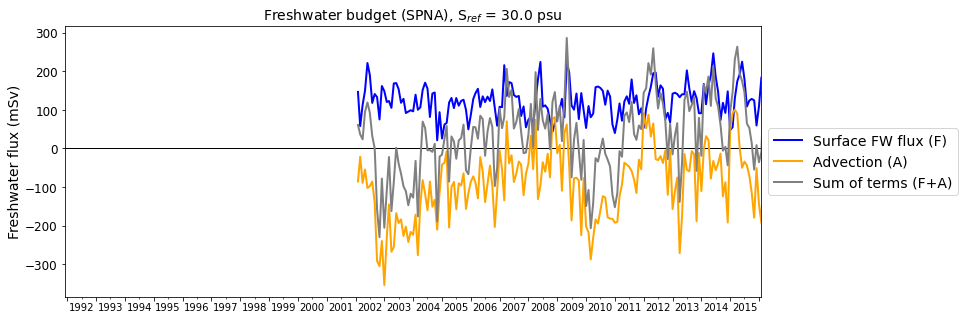

In [36]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (SPNA), S$_{ref}$ = 30.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
#ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='tendFw')*1e3, lw=4, color='black',label='FW tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFw')*1e3, lw=2, color='blue',label='Surface FW flux (F)')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection (A)')
#ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='totalFw')*1e3, lw=2, color='grey',label='Sum of terms (F+A)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])

ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

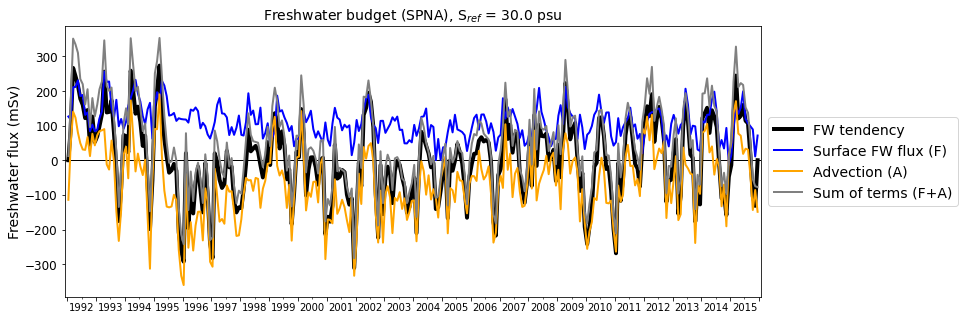

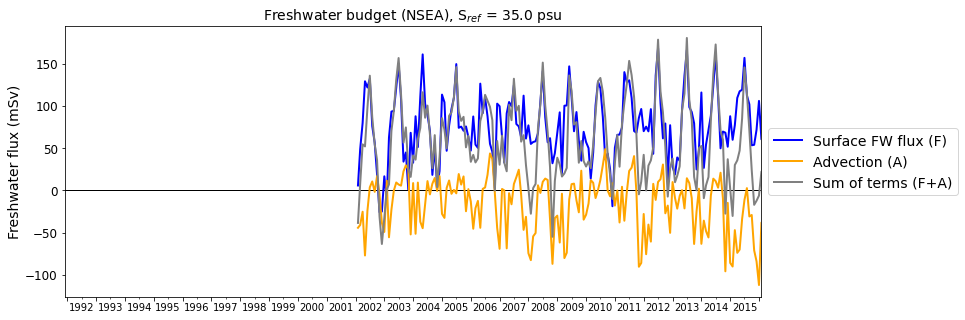

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (NSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
#ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='tendFw')*1e3, lw=4, color='black',label='FW tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFw')*1e3, lw=2, color='blue',label='Surface FW flux (F)')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection (A)')
#ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='totalFw')*1e3, lw=2, color='grey',label='Sum of terms (F+A)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

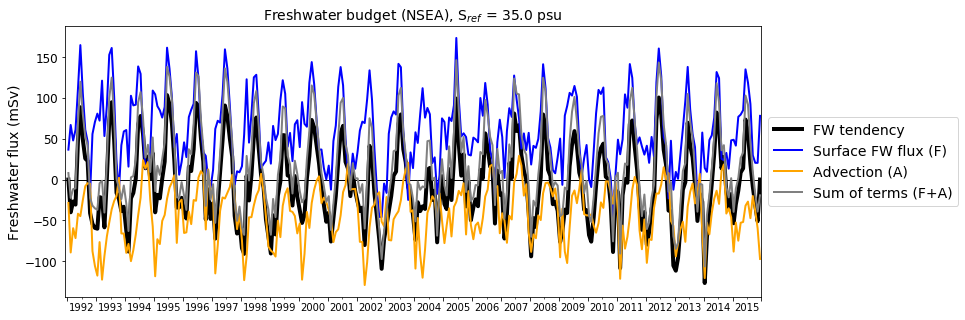

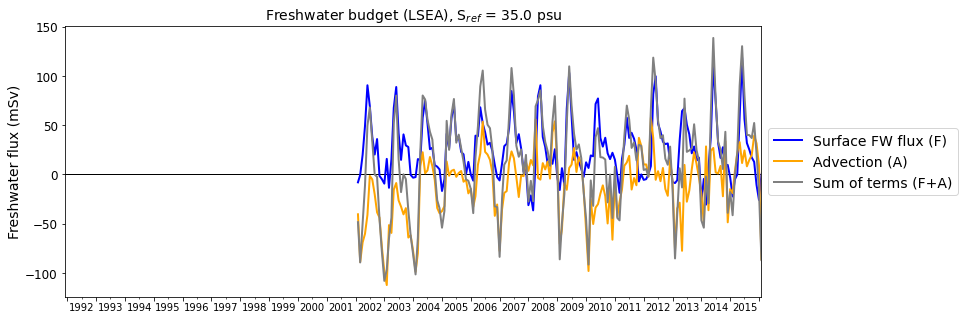

In [40]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (LSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
#ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='tendFw')*1e3, lw=4, color='black',label='FW tendency')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='forcFw')*1e3, lw=2, color='blue',label='Surface FW flux (F)')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='adv_ConvFw')*1e3, lw=2, color='orange',label='Advection (A)')
#ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='dif_ConvFw')*1e3, lw=2, color='purple',label='Diffusion')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='totalFw')*1e3, lw=2, color='grey',label='Sum of terms (F+A)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

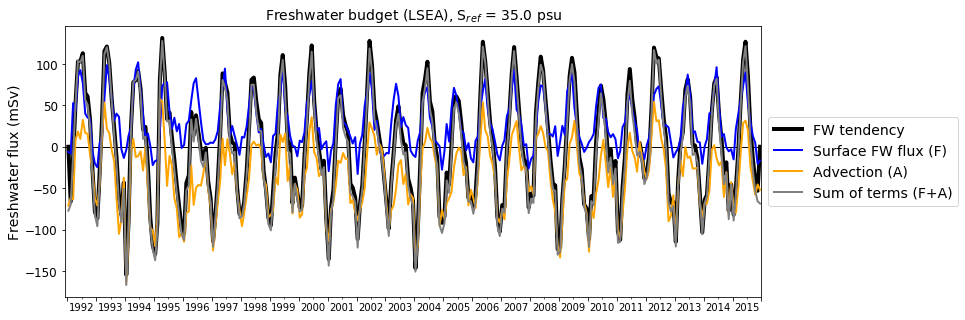

**Default section transports (Boundary fluxes)**

- 'Newfoundland Iberia': into *SPNA*
- 'English Channel': into *SPNA*
- 'Hudson Strait': out of *SPNA* (and out of *LSEA*)
- 'Davis Strait': out of *SPNA* (and out of *LSEA*)
- 'Denmark Strait': out of *SPNA* and into *NSEA*
- 'Iceland Faroe': out of *SPNA* and into *NSEA*
- 'Faroe Scotland': out of *SPNA* and into *NSEA*
- 'Scotland Norway': out of *NSEA*
- 'Fram Strait': out of *NSEA*
- 'Barents Sea': out of *NSEA*
- 'Labrador Greenland': into *LSEA*

In [39]:
ConvFw_spna_bnd = fw_trsp.sel(section='Newfoundland Iberia') + fw_trsp.sel(section='English Channel') \
                    - fw_trsp.sel(section='Hudson Strait') - fw_trsp.sel(section='Davis Strait') \
                    - fw_trsp.sel(section='Denmark Strait') - fw_trsp.sel(section='Iceland Faroe') \
                    - fw_trsp.sel(section='Faroe Scotland')

In [46]:
ConvFw_nsea_bnd = fw_trsp.sel(section='Denmark Strait') + fw_trsp.sel(section='Iceland Faroe') \
                    + fw_trsp.sel(section='Faroe Scotland') + fw_trsp.sel(section='Scotland Norway') \
                    - fw_trsp.sel(section='Fram Strait') - fw_trsp.sel(section='Barents Sea')

In [41]:
ConvFw_lsea_bnd = fw_trsp.sel(section='Labrador Greenland') - fw_trsp.sel(section='Hudson Strait') \
                    - fw_trsp.sel(section='Davis Strait')

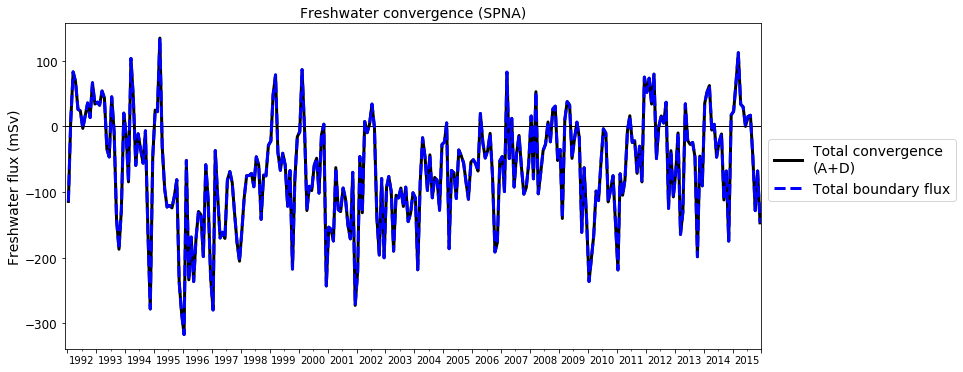

In [42]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='ConvFw')*1e3, lw=3, color='k',
        label='Total convergence\n(A+D)')
ax.plot(ConvFw_spna_bnd.time, ConvFw_spna_bnd*1e3, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

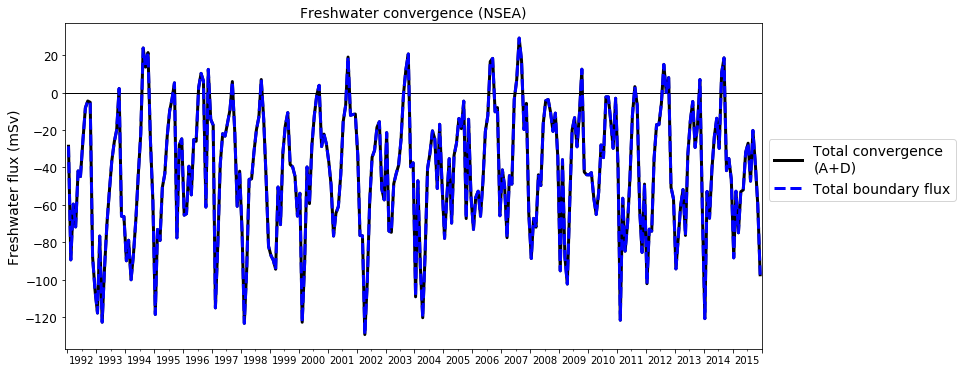

In [47]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='ConvFw')*1e3, lw=3, color='k',
        label='Total convergence\n(A+D)')
ax.plot(ConvFw_nsea_bnd.time, ConvFw_nsea_bnd*1e3, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

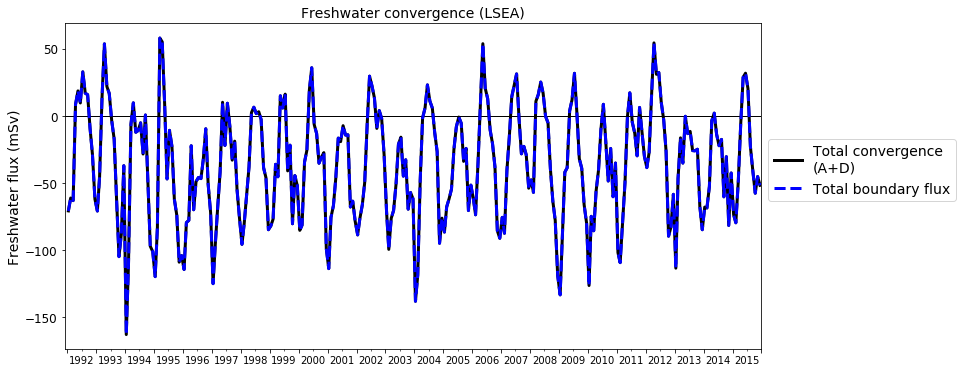

In [45]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='lsea',term='ConvFw')*1e3, lw=3, color='k',
        label='Total convergence\n(A+D)')
ax.plot(ConvFw_lsea_bnd.time, ConvFw_lsea_bnd*1e3, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

In [41]:
v1 = budg_fw.sel(region='spna',term='lfwc') - budg_fw.sel(region='spna',term='lfwc').mean('time')

In [57]:
ecco = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw.nc').budg_fw.sel(time=slice('2002-01-01','2015-12-31'))
aste = xr.open_dataset('/mnt/efs/data/aste/aste_budg_fw.nc').budg_fw

In [58]:
ecco_anom = ecco.groupby('time.month') - ecco.groupby('time.month').mean('time')
aste_anom = aste.groupby('time.month') - aste.groupby('time.month').mean('time')

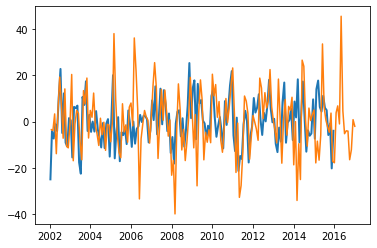

In [65]:
plt.plot(ecco_anom.time, ecco_anom.sel(region='lsea',term='forcFw')*1e3, lw=2,label='ECCO')
plt.plot(aste_anom.time, aste_anom.sel(region='lsea',term='forcFw')*1e3, lw=1.5,label='ASTE')

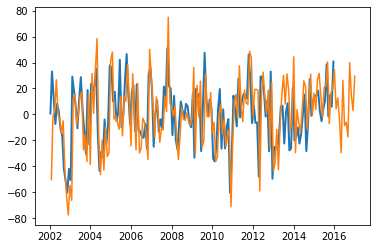

In [66]:
plt.plot(ecco_anom.time, ecco_anom.sel(region='nsea',term='forcFw')*1e3, lw=2,label='ECCO')
plt.plot(aste_anom.time, aste_anom.sel(region='nsea',term='forcFw')*1e3, lw=1.5,label='ASTE')

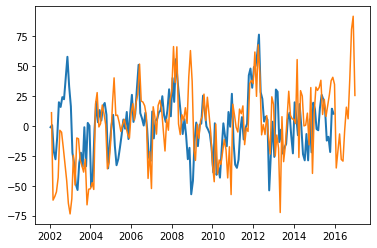

In [64]:
plt.plot(ecco_anom.time, ecco_anom.sel(region='lsea',term='adv_ConvFw')*1e3, lw=2,label='ECCO')
plt.plot(aste_anom.time, aste_anom.sel(region='lsea',term='adv_ConvFw')*1e3, lw=1.5,label='ASTE')

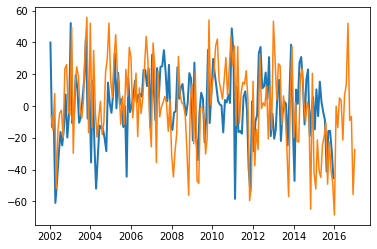

In [63]:
plt.plot(ecco_anom.time, ecco_anom.sel(region='nsea',term='adv_ConvFw')*1e3, lw=2,label='ECCO')
plt.plot(aste_anom.time, aste_anom.sel(region='nsea',term='adv_ConvFw')*1e3, lw=1.5,label='ASTE')

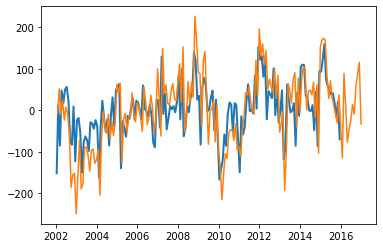

In [59]:
plt.plot(ecco_anom.time, ecco_anom.sel(region='spna',term='adv_ConvFw')*1e3, lw=2,label='ECCO')
plt.plot(aste_anom.time, aste_anom.sel(region='spna',term='adv_ConvFw')*1e3, lw=1.5,label='ASTE')

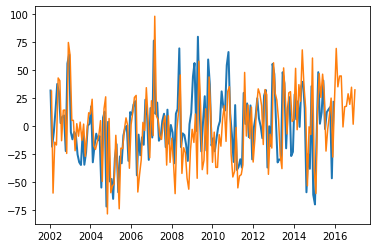

In [60]:
plt.plot(ecco_anom.time, ecco_anom.sel(region='spna',term='forcFw')*1e3, lw=2,label='ECCO')
plt.plot(aste_anom.time, aste_anom.sel(region='spna',term='forcFw')*1e3, lw=1.5,label='ASTE')

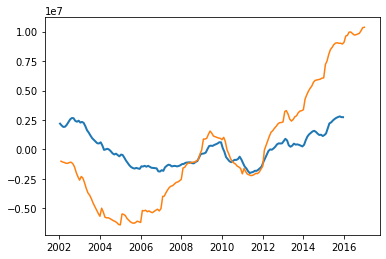

In [62]:
plt.plot(ecco_anom.time, ecco_anom.sel(region='spna',term='lfwc'), lw=2,label='ECCO')
plt.plot(aste_anom.time, aste_anom.sel(region='spna',term='lfwc'), lw=1.5,label='ASTE')

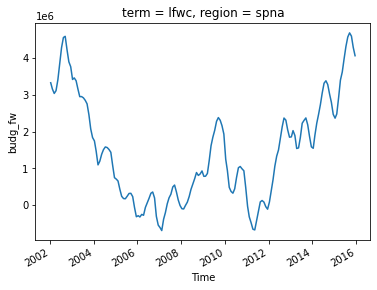

In [61]:
ecco.sel(region='spna',term='lfwc').plot()

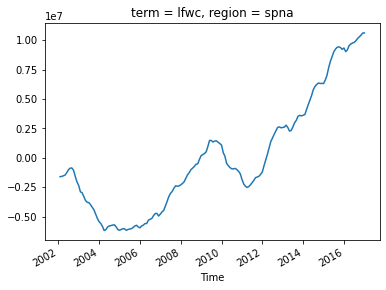

In [42]:
v1.plot()

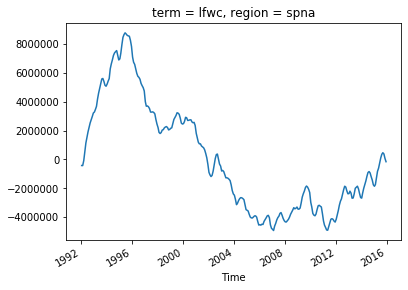

In [46]:
ls /mnt/efs/data/aste/

aste_budg_fw.nc                 aste_lfwc_spna_monthly.nc       zarr/
aste_lfwc_nsea_monthly.nc       aste_lfwc_spna_monthly_anom.nc
aste_lfwc_nsea_monthly_anom.nc  netcdf/


In [47]:
lfwc_spna_ec_monthly = xr.open_dataset('/mnt/efs/data/aste/aste_lfwc_spna_monthly.nc')
lfwc_nsea_ec_monthly = xr.open_dataset('/mnt/efs/data/aste/aste_lfwc_nsea_monthly.nc')

In [49]:
v2 = lfwc_spna_ec_monthly.lfwc - lfwc_spna_ec_monthly.lfwc.mean('time')

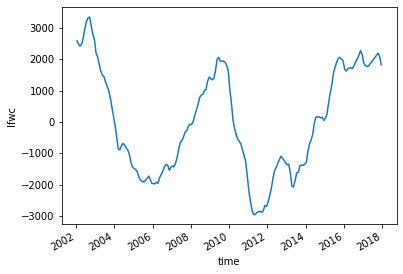

In [50]:
v2.plot()

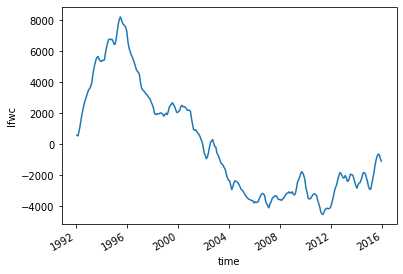

No handles with labels found to put in legend.


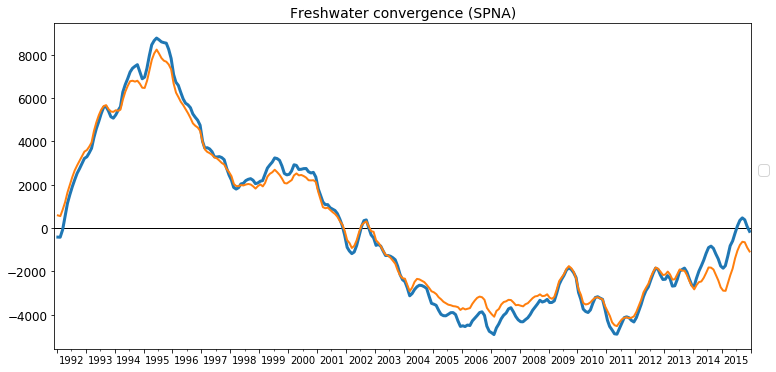

In [77]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Freshwater convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(v1.time, v1*1e-3, lw=3)
ax.plot(v2.tim, v2, lw=2)

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

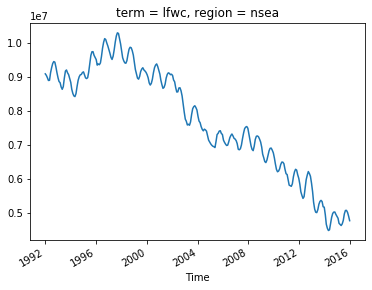

In [57]:
budg_fw.sel(region='nsea',term='lfwc').plot()

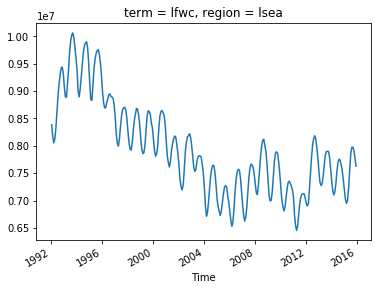

In [58]:
budg_fw.sel(region='lsea',term='lfwc').plot()